In [1]:
%matplotlib inline
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pykitti import odometry

In [2]:
basedir = '/media/ryan/UBUNTU 16_0/data_odometry_gray/dataset'
sequences = []
for i in range(22):
    sequences.append('%02d'%i)
train_sequences = sequences[0:9]
test_sequences = sequences[9:11]

In [3]:
import os
import itertools

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [4]:
def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [6]:
import pickle as p

with open('pose_scaler.p', 'rb') as fp:
    scaler = p.load(fp)

In [11]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/media/ryan/UBUNTU 16_0/train_sfm.tfrecord")
for sequence in train_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.gray(i)
        img = cv2.resize(img, (416, 128))
        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            pose = scaler.transform(pose.flatten().reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
writer.close()
    

Sequence:  00
0
500
1000
1500
2000
2500
3000
3500
4000
4500
Sequence:  01
0
500
1000
Sequence:  02
0
500
1000
1500
2000
2500
3000
3500
4000
4500
Sequence:  03
0
500
Sequence:  04
0
Sequence:  05
0
500
1000
1500
2000
2500
Sequence:  06
0
500
1000
Sequence:  07
0
500
1000
Sequence:  08
0
500
1000
1500
2000
2500
3000
3500
4000


In [12]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/media/ryan/UBUNTU 16_0/eval_sfm.tfrecord")
for sequence in test_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.gray(i)
        img = cv2.resize(img, (416, 128))

        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            pose = scaler.transform(pose.flatten().reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
writer.close()

Sequence:  09
0
500
1000
1500
Sequence:  10
0
500
1000


In [16]:
def parser(record):
    keys_to_features = {
        "pose": tf.FixedLenFeature((), tf.string, default_value=""),
        "img_raw": tf.FixedLenFeature((), tf.string, default_value=""),
        "img_raw_prev": tf.FixedLenFeature((), tf.string, default_value=""),
    }
    parsed = tf.parse_single_example(record, keys_to_features)

    # Perform additional preprocessing on the parsed data.
    image = tf.image.decode_jpeg(parsed["img_raw"])
    image = tf.reshape(image, [128, 416, 1])
    image_prev = tf.image.decode_jpeg(parsed["img_raw_prev"])
    image_prev = tf.reshape(image_prev, [128, 416, 1])
    
    label = tf.decode_raw(parsed["pose"], tf.float64)
    label = tf.reshape(label, [12])

    return image, image_prev, label

Tensor("IteratorGetNext_4:0", shape=(?, 128, 416, 1), dtype=uint8) Tensor("IteratorGetNext_4:1", shape=(?, 128, 416, 1), dtype=uint8)
[[  2.47154847e+02   6.98673146e+02   3.60882172e+01  -3.07354461e-01
    7.03293129e+02   1.04922767e+05   5.85823508e+02   1.62830939e+00
    3.72446266e+01   7.15649850e+02   2.47200289e+02  -1.26552297e-01]
 [  2.47153412e+02   7.00787425e+02   3.56480927e+01  -3.27767957e-01
    7.01123144e+02   1.04922551e+05   5.81867867e+02   1.42101874e+00
    3.76841682e+01   7.20432487e+02   2.47198516e+02   2.70114970e-01]
 [  2.47151006e+02   7.02884620e+02   3.52073692e+01  -3.48207140e-01
    6.98950801e+02   1.04922182e+05   5.77907552e+02   1.21346774e+00
    3.81240508e+01   7.25229701e+02   2.47195561e+02   6.67294779e-01]
 [  2.47147651e+02   7.04959571e+02   3.47671351e+01  -3.68621678e-01
    6.96781438e+02   1.04921678e+05   5.73952319e+02   1.00616818e+00
    3.85631889e+01   7.30029591e+02   2.47191425e+02   1.06400973e+00]
 [  2.47143346e+02   7

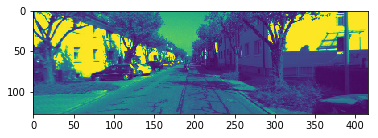

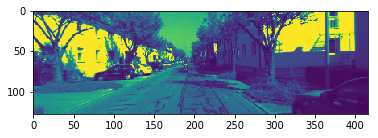

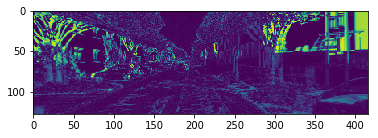

In [19]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(parser)
dataset = dataset.batch(32)
iterator = dataset.make_initializable_iterator()

with tf.Session() as sess:
    # Initialize 'iterator' with training data
    training_filenames = ['/media/ryan/UBUNTU 16_0/train_sfm.tfrecord']
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    images, images_prev, labels = iterator.get_next()
    print (images, images_prev)
    images, images_prev, labels = sess.run([images, images_prev, labels])
    img = images[8].reshape((128, 416))
    img_prev = images_prev[8].reshape((128, 416))

    print (labels)
    plt.imshow(img)
    plt.show()
    plt.figure()
    plt.imshow(img_prev)
    plt.show()
    plt.figure()
    plt.imshow(cv2.absdiff(img, img_prev))
    plt.show()
    
    
#     # Initialize 'iterator' with validation data
#     validation_filenames = ['train01.odometry']
#     sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})
    
    

In [ ]:
[  9.99997800e-01   5.27262800e-04  -2.06693500e-03  -4.69029400e-02
  -5.29650600e-04   9.99999200e-01  -1.15486500e-03  -2.83992800e-02
   2.06632400e-03   1.15595800e-03   9.99997100e-01   8.58694100e-01]